In [26]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_name = 'optimized_trajectories/path_dense_random_columns_4obj'
# file_name = 'optimized_trajectories/path_dense_random_columns'
file_path = file_name + '.csv'
df = pd.read_csv(file_path)

N = df.shape[0] # horizon+1
q_ref = np.empty(( N, 4, 4 ))
xi_ref = np.empty(( N, 6, ))

df.columns

Index(['t', 'p_x', 'p_y', 'p_z', 'q_w', 'q_x', 'q_y', 'q_z', 'v_x', 'v_y',
       'v_z', 'w_x', 'w_y', 'w_z', 'a_lin_x', 'a_lin_y', 'a_lin_z', 'u_1',
       'u_2', 'u_3', 'u_4', 'comm_t', 'comm_id', 'comm_type'],
      dtype='object')

In [20]:
import sys
sys.path.append('..')
from traoptlibrary.traopt_utilis import quat2rotm, quatpos2SE3, rotm2euler

position_columns = ['p_x', 'p_y', 'p_z']
quaternion_columns = ['q_w', 'q_x', 'q_y', 'q_z']
quaternion_columns_xyzw = ['q_x', 'q_y', 'q_z', 'q_w']
pos = df[ position_columns ].to_numpy()
quat = df[ quaternion_columns ].to_numpy()
quat_xyzw = df[quaternion_columns_xyzw].to_numpy()
romt = np.array([ quat2rotm(x) for x in quat ])
quatpos = df[quaternion_columns + position_columns].to_numpy()
q_ref = np.array([ quatpos2SE3(x) for x in quatpos ])

translation_velocity_columns = ['v_x', 'v_y', 'v_z']
v_world = df[translation_velocity_columns].to_numpy()
v_ref = np.array([ romt[i].T @ (v_world[i].reshape(3,1)) for i in range(N) ]).reshape(N, 3)
xi_ref[:,3:] = v_ref.copy()

angular_velocity_columns = ['w_x', 'w_y', 'w_z']
w = df[angular_velocity_columns].to_numpy()
xi_ref[:,:3] = w.copy()

angle_euler = np.array([ rotm2euler(x) for x in romt ] )

In [21]:
with open(file_name+'.npy', 'wb') as f:
    np.save(f, q_ref)
    np.save(f, xi_ref)

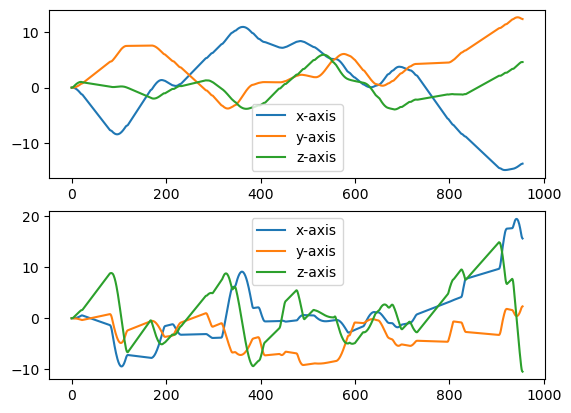

In [22]:
plt.figure()
plt.subplot(211)
plt.plot( v_world, label=['x-axis','y-axis','z-axis'] )
plt.legend()

plt.subplot(212)
plt.plot( v_ref, label=['x-axis','y-axis','z-axis'] )
plt.legend()

plt.show()

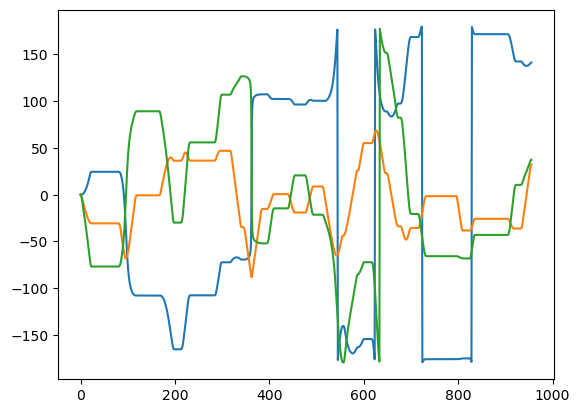

In [23]:
plt.figure()
plt.plot( angle_euler )
plt.show()

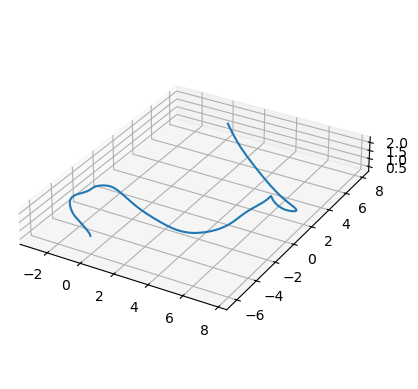

In [24]:
positions = df[ position_columns ]

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D( positions['p_x'],positions['p_y'],positions['p_z'] )
ax.set_aspect('equal')
plt.show()

In [7]:
# with open(file_name+'.npy', 'rb') as f:
#     q_ref = np.load(f)
#     xi_ref = np.load(f)

Ultimate goal is to obtain `q_ref`, `xi_ref`

In [25]:
import rerun as rr
import numpy as np
import sys
import os
sys.path.append("rerun_visualization")
from rerun_loader_urdf import URDFLogger
from scipy.spatial.transform import Rotation

# Initialization
# os.system('export MESA_D3D12_DEFAULT_ADAPTER_NAME=NVIDIA')
# os.system('rerun --web-viewer --renderer=webgl')
rr.init("trajectory_animation", spawn=True)


drone_urdf_path = "./rerun/drone.urdf"
urdf_logger = URDFLogger(drone_urdf_path, None)

urdf_logger.entity_path_prefix = f"drone/urdf"
urdf_logger.log()

dt = 0.01

rr.log_file_from_path( "./rerun/random_columns_without_roof.obj" )

for step in range(N):

    rr.set_time_seconds( "sim_time", dt * step )
    
    rr.log(
        f"trajectory/position",
        rr.Points3D(
            pos[step] #,
            # colors=vel_mapped_color,
        ),
    )

    rr.log(
        f"drone/urdf",
        rr.Transform3D(
            translation=pos[step],
            rotation=rr.Quaternion(xyzw=quat_xyzw[step]),
            axis_length=1.0,
        ),
    )

[2024-12-09T18:30:28Z INFO  re_sdk::spawn] A process is already listening at this address. Assuming it's a Rerun Viewer. addr=0.0.0.0:9876
[2024-12-09T18:30:28Z INFO  re_data_loader::load_file] Loading "rerun_visualization/random_columns_without_roof.obj"…
[2024-12-09T18:30:30Z ERROR re_data_loader::loader_external] Failed to execute external loader filepath="rerun_visualization/random_columns_without_roof.obj" loader="/home/chenghuailin/.local/bin/rerun-loader-urdf" reason=usage: rerun-loader-urdf [-h] [--application-id APPLICATION_ID]
                             [--recording-id RECORDING_ID]
                             [--entity-path-prefix ENTITY_PATH_PREFIX]
                             [--timeless] [--time TIME] [--sequence SEQUENCE]
                             filepath
    rerun-loader-urdf: error: unrecognized arguments: --opened-application-id trajectory_animation --opened-recording-id 79a6b78f-00aa-4370-bffc-4a3534aa937d
    
